**Question 1**
> On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of \\$3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

> **a) Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.**

We are interested in the Average Order Value metric. Traditionally, AOV is calculated as revenue/number of orders. The naive calculation has determined that the AOV is $3145.13 which is higher than what we would expect for sneaker sales. Let's first confirm that this number was obtained from taking the mean `order_amount`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

df = pd.read_csv("/kaggle/input/shoe-sales/shoe-sales.csv")
df.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

Looks like the AOV was calculated as the mean `order_amount`. We know that the mean is higher than we would expect, and that the dataset has a very high standard deviation (exteremly spread out). Let's try to see if we can get a sense of what the data looks like to explain what might be skewing the mean.

array([[<AxesSubplot:title={'center':'order_amount'}>]], dtype=object)

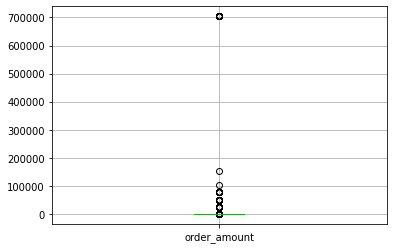

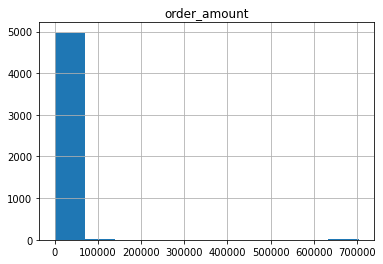

In [2]:
df.boxplot(column='order_amount')
df.hist(column="order_amount")

In [3]:
df.order_amount.median()

284.0

Evidently, our median (the green line) is **far** less than our current AOV.

Further, it looks like we have one **extreme** outlier and several other large orders that are skewing our mean. Let's take a look at the 20 orders of the largest value to try to get some insight.

In [4]:
df.sort_values(by='order_amount', ascending=False).head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
2835,2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
4882,4883,42,607,704000,2000,credit_card,2017-03-25 4:00:00


Interesting. It looks like we have many repeated orders of \\$704,000 all from `user_id` 607 to `shop_id` 42.

In [5]:
large_order_amount = 704000
large_order_quantity = 2000
print("Price per unit $" + str(large_order_amount/large_order_quantity))

Price per unit $352.0


It looks like the cost per shoe here is fairly reasonable but the quantity is very high. Let's take a look at the `total_items` column to see how unusual this order quantity is.

The median order quantity is: 2.0


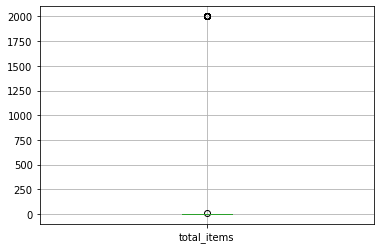

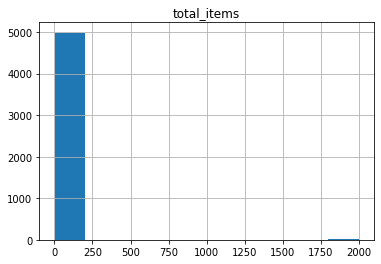

In [6]:
df.boxplot(column="total_items")
df.hist(column="total_items")
print("The median order quantity is: " + str(df.total_items.median()))

Looks like these high quantity orders are very unusual. The median order quantity is only two pairs of shoes, and it seems like these orders of 2000 pairs are the far from even the closest outlier.

I would assume that what we are looking at here are orders from some sort of retailer or re-seller who is ordering in bulk to supply inventory for their store. But this use case seems highly uncommon, and likely an outlier that we can omit from a more reasonable AOV calculation.

In [7]:
df_no_supplier_orders = df[(df.order_amount < 704000)]
df_no_supplier_orders.order_amount.describe()

count      4983.000000
mean        754.091913
std        5314.092293
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      154350.000000
Name: order_amount, dtype: float64

This seems much better. Once we remove the supplier orders we have a new mean of \\$754.09. But the standard deviation is still very high, more than \\$5000! Let's dig deeper into what might be skewing our calculation.

In [8]:
df_no_supplier_orders.sort_values(by='order_amount', ascending=False).head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
691,692,78,878,154350,6,debit,2017-03-27 22:51:43
2492,2493,78,834,102900,4,debit,2017-03-04 4:37:34
3724,3725,78,766,77175,3,credit_card,2017-03-16 14:13:26
1259,1260,78,775,77175,3,credit_card,2017-03-27 9:27:20
4420,4421,78,969,77175,3,debit,2017-03-09 15:21:35
2564,2565,78,915,77175,3,debit,2017-03-25 1:19:35
2906,2907,78,817,77175,3,debit,2017-03-16 3:45:46
4715,4716,78,818,77175,3,debit,2017-03-05 5:10:44
3403,3404,78,928,77175,3,debit,2017-03-16 9:45:05
4192,4193,78,787,77175,3,credit_card,2017-03-18 9:25:32


It looks like we have one **very** expensive store. `shop_id` 78 is selling \\$25725 sneakers!! Let's look at how many transactions have come from `shop_id` 78

count        46.000000
mean      49213.043478
std       26472.227449
min       25725.000000
25%       25725.000000
50%       51450.000000
75%       51450.000000
max      154350.000000
Name: order_amount, dtype: float64


<AxesSubplot:>

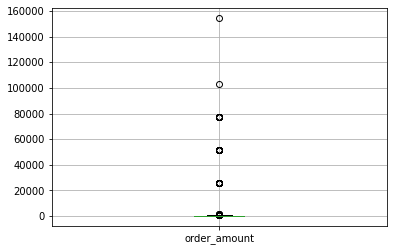

In [9]:
print(df.loc[df['shop_id'].isin([78])].order_amount.describe())
df_no_supplier_orders.boxplot(column='order_amount')

Looks like we have 46/5000 transactions coming from `shop_id` 78. And **all** of them are more than 3 standard deviations away from the mean of our truncated data set. Let's try removing these premium sales and analyzing at what happens.

In [10]:
df_no_suppliers_no_premium = df[(df.order_amount < 704000) & (df.shop_id != 78)]
df_no_suppliers_no_premium.order_amount.describe()

count    4937.000000
mean      302.580514
std       160.804912
min        90.000000
25%       163.000000
50%       284.000000
75%       387.000000
max      1760.000000
Name: order_amount, dtype: float64

Ahh, much better! Now our median is only \\$300 and our standard deviation is pretty reasonable.

Truncated median: $284.0


<AxesSubplot:>

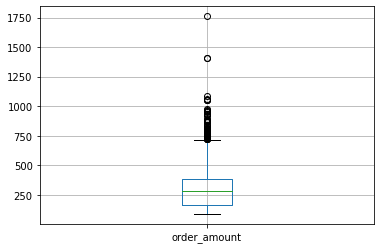

In [11]:
print("Truncated median: $" + str(df_no_suppliers_no_premium.order_amount.median()))
df_no_suppliers_no_premium.boxplot(column='order_amount')

Our standard deviation is now much lower, in the hundreds of dollars seems to be a much more appropriate magnitude for sneaker sales.

It seems like what went wrong with the naive analysis was that it did not account for a few distinct outliers. Since the outliers happened to be extremely large in value, and not balanced with any small outliers (because \\$0 or negative pruchases don't make sense) the mean calculation ended up being heavily skewed by a few high-value premium orders.

> **b) What metric would you report for this dataset?**


To avoid bias in our calculation from a few orders of very high value, I would prefer a median calculation. This calculation will determine the AOV by looking at the 50% quantile which is a relative calculation that won't be thrown off by a few expensive orders. 

> **c) What is the value of this metric?**


In [12]:
print("Median AOV: $" + str(df.order_amount.median()))

Median AOV: $284.0


It's easy to show that this is a less-biased metric, because if we look at the median AOV of our truncated dataset, it is exactly the same.

In [13]:
print("Median AOV: $" + str(df_no_suppliers_no_premium.order_amount.median()))

Median AOV: $284.0


**Question 2**
> For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

> **a) How many orders were shipped by Speedy Express in total?**

In [ ]:
SELECT COUNT(*) AS orders_shipped
FROM Orders
JOIN Shippers ON Shippers.ShipperID = Orders.ShipperID
WHERE Shippers.ShipperName = 'Speedy Express';

Answer: **54**

> **b) What is the last name of the employee with the most orders?**

In [ ]:
SELECT Employees.LastName
FROM Orders
INNER JOIN Employees ON Orders.EmployeeID = Employees.EmployeeID
GROUP BY Orders.EmployeeID
ORDER BY COUNT(Orders.EmployeeID) DESC
LIMIT 1;

Answer: **Peacock**

> **c) What product was ordered the most by customers in Germany?**

In [ ]:
SELECT Products.ProductName
FROM Orders
JOIN Products
    ON Products.ProductID = OrderDetails.ProductID
JOIN OrderDetails
    ON OrderDetails.OrderID = Orders.OrderID
JOIN Customers
    ON Customers.CustomerID = Orders.CustomerID
WHERE [Customers].Country = 'Germany'
GROUP BY [OrderDetails].ProductID
ORDER BY SUM([OrderDetails].Quantity) DESC 
LIMIT 1;

Answer: **Boston Crab Meat**